# Predicting heart disease using machine learning


This notebook looks into using variopus python-based machine learning and dsta science libraries in an na attempt to buiuld a machine learning model capable of predicting whether or not someonehas heart disease based on thier medical attributes.

1. Problem definition
2. Data
3. Evaluation
4. Features
5. Modelling
5. Experimentation

## 3. Evaluation

> If we can reach 95% accuracy at prediction during proof of concept, we'll pursue the project. What is proof of concept?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

In [2]:
heart_data = pd.read_csv('heart.csv')

In [3]:
heart_data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


<AxesSubplot:>

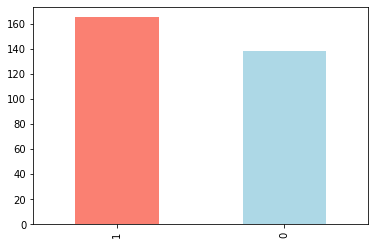

In [4]:
heart_data.target.value_counts().plot(kind = "bar", color = ["salmon", "lightblue"])

In [5]:
heart_data.target.describe()

count    303.000000
mean       0.544554
std        0.498835
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: target, dtype: float64

## Heart Disease Frequency according to Sex

In [6]:
heart_data.sex.value_counts()

1    207
0     96
Name: sex, dtype: int64

In [7]:
#compare target column with sex column
pd.crosstab(heart_data.target, heart_data.sex)

sex,0,1
target,,
0,24,114
1,72,93


(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

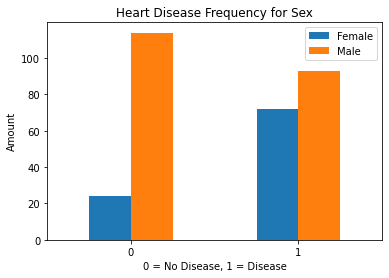

In [8]:
#change the sex values. if value is 1 = male, 0 = female
pd.crosstab(heart_data.target, heart_data.sex).plot(kind = "bar", fig = (10, 6))
plt.title("Heart Disease Frequency for Sex")
plt.xlabel("0 = No Disease, 1 = Disease")
plt.ylabel("Amount")
plt.legend(['Female', 'Male'])
plt.xticks(rotation = 0)

## Age vs. Max Heart Rate for Heart Disease

In [9]:
heart_data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


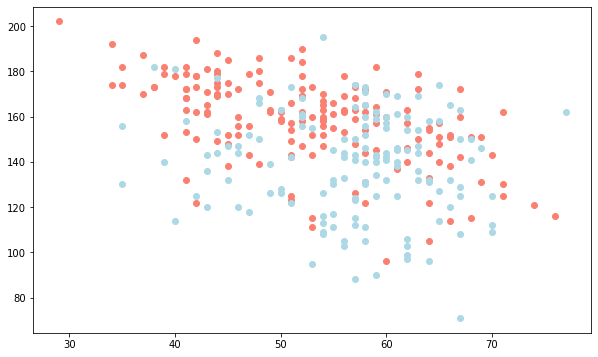

In [10]:
#age vs thalac(max heart rate achieved)
plt.figure(figsize = (10, 6))

#positive examples
plt.scatter(heart_data.age[heart_data.target==1],
            heart_data.thalach[heart_data.target==1],
            c = "salmon")

#negative examples
plt.scatter(heart_data.age[heart_data.target == 0], heart_data.thalach[heart_data.target == 0], c = "lightblue")

<AxesSubplot:ylabel='Frequency'>

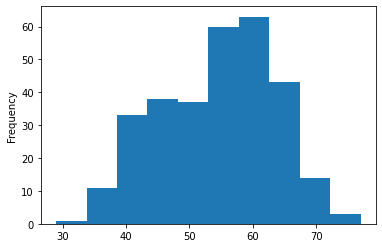

In [11]:
#checking the distribution of the age
heart_data.age.plot.hist()

## Heart Disease frequency per chest pain type

 cp: chest pain type
-- Value 1: typical angina
-- Value 2: atypical angina
-- Value 3: non-anginal pain
-- Value 4: asymptomatic


In [12]:
#seeing trends in chest pain type vs heart disease frequency
pd.crosstab(heart_data.cp, heart_data.target)

target,0,1
cp,,
0,104,39
1,9,41
2,18,69
3,7,16


(array([0, 1, 2, 3]),
 [Text(0, 0, '0'), Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3')])

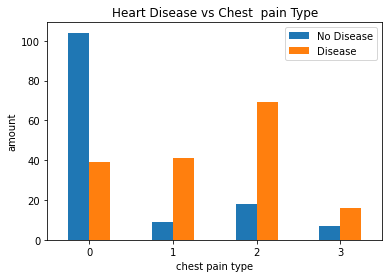

In [13]:
#seeing trends in chest pain type vs heart disease frequency
pd.crosstab(heart_data.cp, heart_data.target).plot(kind = "bar", fig = (10, 6))

plt.title("Heart Disease vs Chest  pain Type")
plt.xlabel("chest pain type")
plt.ylabel("amount")
plt.legend(["No Disease", "Disease"])
plt.xticks(rotation = 0)

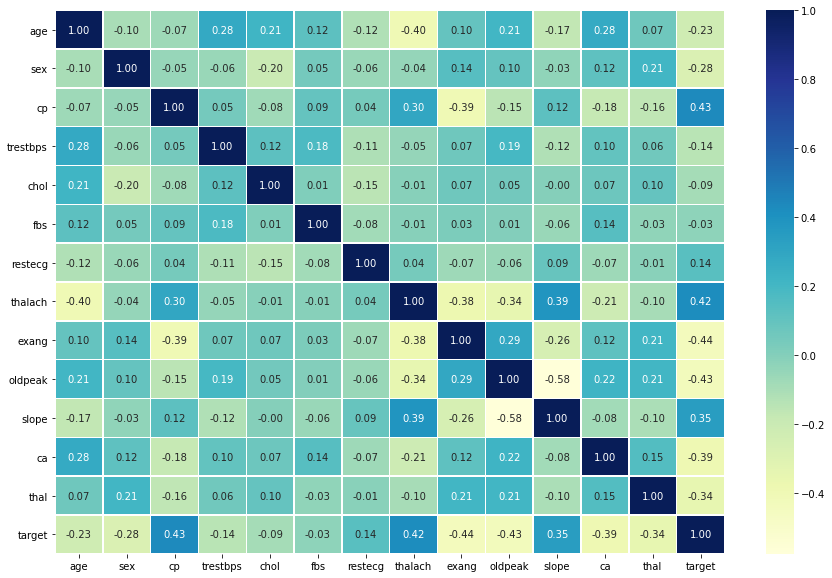

In [14]:
#see rough idea on which data has a correlation with which data - gain insights hereddddd
corr_matrix = heart_data.corr()
fig, ax = plt.subplots(figsize = (15, 10))
ax = sns.heatmap(corr_matrix, 
                annot = True, 
                linewidths = 0.5, 
                fmt = ".2f",
                cmap = "YlGnBu")

## 5. Modeling 

In [15]:
x = heart_data.drop("target", axis = 1) #axis = 1 means drop the column
y = heart_data["target"]

In [16]:
#split to train and test set.
np.random.seed(42) #the 42 ensures that the random data used is stored(else everytime random data comes back, it will be diff)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

In [17]:
y_train, len(y_train)

(132    1
 202    0
 196    0
 75     1
 176    0
       ..
 188    0
 71     1
 106    1
 270    0
 102    1
 Name: target, Length: 242, dtype: int64,
 242)

In [18]:
# put models in a dictionary
models = {"Logistic Regression": LogisticRegression(),
         "KNN": KNeighborsClassifier(),
         "Random Forest" : RandomForestClassifier()}


#function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    np.random.seed(42)
    model_scores = {} #dict to keep model scores
    
    #loop through each model
    for name, model in models.items():
        model.fit(X_train, y_train)
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [19]:
model_scores = fit_and_score(models, X_train, X_test, y_train, y_test)
model_scores

C:\Users\masyr\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


{'Logistic Regression': 0.8852459016393442,
 'KNN': 0.6885245901639344,
 'Random Forest': 0.8360655737704918}

## Model Comparison 

<AxesSubplot:>

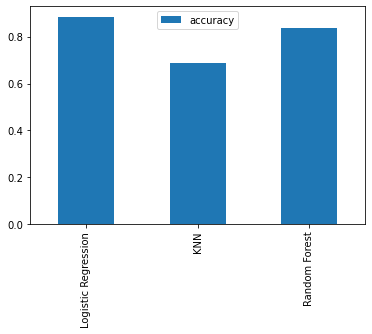

In [20]:
model_compare = pd.DataFrame(model_scores, index = ["accuracy"]) 
model_compare.T.plot.bar()

#Hyperparameter tuning
#feature importance
#--------specific to classification models
#confusion matrix
#precision
#recall
#f1 score
#classification report
#ROC curve
#Area under curve (AUC)

## Hyperparameter tuning

In [21]:
#tune KNN

train_scores = []
test_scores = []

#list of diff values for n_neighbors
neighbors = range(1, 21)

#setup KNN instance
knn = KNeighborsClassifier()

#Loop through different n_neighbors
for num in neighbors:
    
    knn.set_params(n_neighbors = num)
    
    knn.fit(X_train, y_train)
    
    #update training scorest list.
    train_scores.append(knn.score(X_train, y_train))
    
    #updates test
    test_scores.append(knn.score(X_test, y_test))
    
    


Maximum knn score on test data: 75.41%


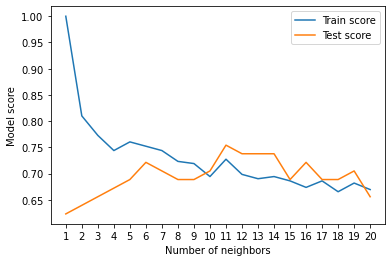

In [22]:
plt.plot(neighbors, train_scores, label = "Train score")
plt.plot(neighbors, test_scores, label = "Test score")
plt.xticks(np.arange(1,21,1))
plt.xlabel("Number of neighbors")
plt.ylabel("Model score")
plt.legend()

#with hyper parameter tuning, we improve KNN accuracy from 68% to 75.41%
print(f"Maximum knn score on test data: {max(test_scores)*100:.2f}%")

## Hyperparameter tuning with RandomizedSearchCV

In [23]:
#create hyperparameter grid for logisticregression
log_reg_grid = {"C": np.logspace(-4, 5, 20),
               "solver": ["liblinear"]}

#create hyperparameter grid for RandomForesClassifier
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [None, 3, 5, 10],
          "min_samples_split": np.arange(2, 20, 2),
          "min_samples_leaf":np.arange(1, 20, 2)}

In [24]:
#tune logistric regression
np.random.seed(42)

#setup random hyperparameter search for logistricregression
rs_log_reg = RandomizedSearchCV(LogisticRegression(), #the model to use
                               log_reg_grid, #the parameters we want to test
                               n_iter = 20, #number of iterations/ models to train
                               cv = 5, #number of folds
                               verbose = True) 

#fit random hyperparameter search model for logistic regression
rs_log_reg.fit(X_train, y_train)



Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 2.97635144e-04, 8.85866790e-04, 2.63665090e-03,
       7.84759970e-03, 2.33572147e-02, 6.95192796e-02, 2.06913808e-01,
       6.15848211e-01, 1.83298071e+00, 5.45559478e+00, 1.62377674e+01,
       4.83293024e+01, 1.43844989e+02, 4.28133240e+02, 1.27427499e+03,
       3.79269019e+03, 1.12883789e+04, 3.35981829e+04, 1.00000000e+05]),
                                        'solver': ['liblinear']},
                   verbose=True)

In [25]:
rs_log_reg.best_params_ #check the best params 

{'solver': 'liblinear', 'C': 0.2069138081114788}

In [26]:
rs_log_reg.score(X_test, y_test) #the logistric regression out of the box has similar results to the one with tuned hyperparameters

0.8852459016393442

In [27]:
#setup random serach classifier for Random forest
rs_ran_for  = RandomizedSearchCV(RandomForestClassifier(), 
                                rf_grid,
                                cv = 5, 
                                n_iter = 20,
                                verbose = True)

#fit random hyperpatemeter for random forst classifier
rs_ran_for.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.4min finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [28]:
rs_ran_for.best_params_

{'n_estimators': 360,
 'min_samples_split': 4,
 'min_samples_leaf': 15,
 'max_depth': 5}

In [29]:
rs_ran_for.score(X_test, y_test)#score improved by 1%

0.8688524590163934

## Hyperparameter tuning with gridsearchcv 

In [30]:
#different hyperparamaters for logistic regression:
log_reg_grid = {"C": np.logspace(-4, 4, 30),
               "solver":["liblinear"]}

#setup grid hyperparameter search for logistic regression
gs_log_reg = GridSearchCV(LogisticRegression(),
                          param_grid = log_reg_grid,
                          cv = 5,
                          verbose = True)

#fit grid hyperparameter search model
gs_log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.7s finished


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 1.88739182e-04, 3.56224789e-04, 6.72335754e-04,
       1.26896100e-03, 2.39502662e-03, 4.52035366e-03, 8.53167852e-03,
       1.61026203e-02, 3.03919538e-02, 5.73615251e-02, 1.08263673e-01,
       2.04335972e-01, 3.85662042e-01, 7.27895384e-01, 1.37382380e+00,
       2.59294380e+00, 4.89390092e+00, 9.23670857e+00, 1.74332882e+01,
       3.29034456e+01, 6.21016942e+01, 1.17210230e+02, 2.21221629e+02,
       4.17531894e+02, 7.88046282e+02, 1.48735211e+03, 2.80721620e+03,
       5.29831691e+03, 1.00000000e+04]),
                         'solver': ['liblinear']},
             verbose=True)

In [31]:
gs_log_reg.best_params_

{'C': 0.20433597178569418, 'solver': 'liblinear'}

In [32]:
gs_log_reg.score(X_test, y_test) #around the same result without hyperparameter tuning.

0.8852459016393442

## Evaluation the tuned machine learning classified, beyond just measuring accuracy

* ROC curve and AUC score
* Confusion matrix
* Classification Report
* Precision
* Recall 
* F1- Score


In [40]:
y_pred = gs_log_reg.score(X_test, y_test)
y_preds = gs_log_reg.predict(X_test)

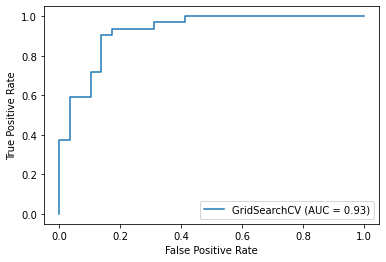

In [34]:
#plot roc curve and calc + calc auc metric
plot_roc_curve(gs_log_reg, X_test, y_test)

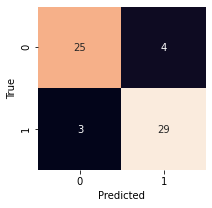

In [42]:
#plot a confusion_matrix 

def plot_conf_mat(y_test, y_preds):
    fig, ax = plt.subplots(figsize = (3,3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                    annot = True,
                    cbar = False)
    
    plt.xlabel("Predicted")
    plt.ylabel("True")
    
    
plot_conf_mat(y_test, y_preds)
    

In [43]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.89      0.86      0.88        29
           1       0.88      0.91      0.89        32

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.89        61



## Calculate evaluation metrics using cross-validation



In [44]:
#check best hyperparamaters
gs_log_reg.best_params_

{'C': 0.20433597178569418, 'solver': 'liblinear'}

In [46]:
#classifier with best params
clf = LogisticRegression(C= gs_log_reg.best_params_["C"], solver =gs_log_reg.best_params_["solver"] )

In [53]:
#cross-validated accuracy
cv_acc = cross_val_score(clf, x, y, cv = 5, scoring = "accuracy")
cv_acc

array([0.81967213, 0.90163934, 0.8852459 , 0.88333333, 0.75      ])

In [54]:
cv_acc = np.mean(cv_acc)
cv_acc

0.8479781420765027

In [55]:
#cross validated precision
cv_precision = cross_val_score(clf, x, y, cv = 5, scoring = "precision")
cv_precision = np.mean(cv_precision)
cv_precision

0.8215873015873015

In [56]:
#cross validated recall
cv_recall = cross_val_score(clf, x, y, cv = 5, scoring = "recall")
cv_recall = np.mean(cv_recall)
cv_recall

0.9272727272727274

In [57]:
#cross validated recall
cv_f1 = cross_val_score(clf, x, y, cv = 5, scoring = "f1")
cv_f1  = np.mean(cv_f1)
cv_f1 

0.8705403543192143

<AxesSubplot:title={'center':'Cross-Validated classification metrics'}>

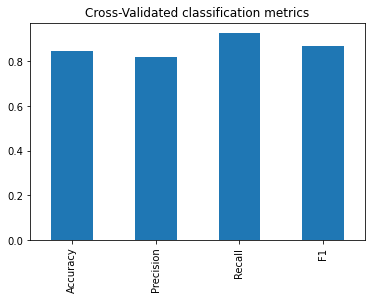

In [60]:
#Visualize cv metrics
cv_metrics = pd.DataFrame({"Accuracy": cv_acc,
                          "Precision": cv_precision, 
                          "Recall": cv_recall,
                          "F1":cv_f1},
                         index = [0])
cv_metrics.T.plot.bar(title = "Cross-Validated classification metrics", legend = False)

## Feature importance - features that contribute the most to the outcomes of the model

In [62]:
#Fit instance of logistic regression
clf = LogisticRegression(C = gs_log_reg.best_params_["C"], solver = gs_log_reg.best_params_["solver"])
clf.fit(X_train, y_train)

LogisticRegression(C=0.20433597178569418, solver='liblinear')

In [63]:
#check coef_
clf.coef_

array([[ 0.00316728, -0.86044636,  0.66067051, -0.01156993, -0.00166374,
         0.04386116,  0.31275829,  0.02459361, -0.60413071, -0.56862818,
         0.45051626, -0.63609888, -0.67663381]])

In [64]:
#match coefs of features to columns.
feature_dict = dict(zip(heart_data.columns, list(clf.coef_[0])))
feature_dict

{'age': 0.003167278990517721,
 'sex': -0.8604463644626569,
 'cp': 0.6606705054012705,
 'trestbps': -0.011569931335912368,
 'chol': -0.0016637438070300692,
 'fbs': 0.04386116284216185,
 'restecg': 0.31275829369964075,
 'thalach': 0.02459361297137234,
 'exang': -0.6041307139378419,
 'oldpeak': -0.5686281825180214,
 'slope': 0.450516263738603,
 'ca': -0.6360988840661891,
 'thal': -0.6766338062111971}

<AxesSubplot:title={'center':'Feature Importance'}>

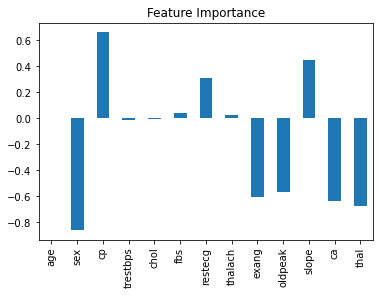

In [66]:
#visualize feature importance
feature_df = pd.DataFrame(feature_dict, index = [0])
feature_df.T.plot.bar(title = "Feature Importance", legend = False)

## 6. Experimentation

- Havent reached goal accuracy of 95%, now only at 88%.
Possible things to do: 
* Collect more data? Different data?
* Try a better model? Catboost? Xgboost?
* Improve current model?